# Imports

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing

In [4]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('./PetImages/Dog'))

n_cats = len(os.listdir('./PetImages/Cat'))

n_images = [n_cats, n_dogs]

px.pie(names=class_names, values=n_images)

# Create directories for training and validation

In [ ]:
# try:
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
#   os.mkdir('/tmp/cats-v-dogs')
# except OSError:
#   print("Error failed to make directory")

: 

In [10]:
# Define data path

CAT_DIR = './PetImages/Cat'
DOG_DIR = './PetImages/Dog'

TRAINING_DIR = './cats-v-dogs/training'
VALIDATION_DIR = './cats-v-dogs/validation'
TEST_DIR = './cats-v-dogs/test'

TRAINING_CATS = os.path.join(TRAINING_DIR, 'cats/')
VALIDATION_CATS = os.path.join(VALIDATION_DIR, 'cats/')
TEST_CATS = os.path.join(TEST_DIR, 'cats/')

TRAINING_DOGS = os.path.join(TRAINING_DIR, 'dogs/')
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, 'dogs/')
TEST_DOGS = os.path.join(TEST_DIR, 'dogs/')

# Define whether to include test split or not
INCLUDE_TEST = True

In [6]:
print(len(os.listdir(TRAINING_CATS)))

0


In [7]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.9):
  """
  Splits the data into train validation and test sets (optional)

  Args:
  main_dir (string): path containing the images
  training_dir (string): path to be used for training
  validation_dir (string): path to be used for validation
  test_dir (string): path to be used for test
  include_test_split (boolean): whether to include a test split or not
  split_size (float): size of the dataset to be used for training
  """
  files = []

  for file in os.listdir(main_dir):
    if os.path.getsize(os.path.join(main_dir, file)): # check if file size isn't 0
      files.append(file) # appends file name to a list
    
  shuffled_files = random.sample(files, len(files)) # shuffles the data

  split = int(0.9 * len(shuffled_files)) # the training split casted into int for numeric rounding

  train = shuffled_files[:split] # training split
  split_valid_test = int(split + (len(shuffled_files) - split) / 2) # the index of half of the remaining data (except train) <=> len(validation) == len(test)


  if include_test_split:
    validation = shuffled_files[split:split_valid_test] # validation split
    test = shuffled_files[split_valid_test:]
  else:
    validation = shuffled_files[split:]
  
  for element in train:
    copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element)) # copy file into training directory

  for element in validation:
    copyfile(os.path.join(main_dir, element), os.path.join(validation_dir, element)) # copy file into validation directory

  if include_test_split:
    for element in test:
      copyfile(os.path.join(main_dir, element), os.path.join(test_dir, element)) # copy files into test directory

  print('Successful')



# Now let's call the function to create the training/validation data

In [11]:
split_data(CAT_DIR, TRAINING_CATS, VALIDATION_CATS, TEST_CATS, INCLUDE_TEST, 0.9)
split_data(DOG_DIR, TRAINING_DOGS, VALIDATION_DOGS, TEST_DOGS, INCLUDE_TEST, 0.9)

Successful
Successful


In [12]:
print(len(os.listdir(TRAINING_CATS)))
print(len(os.listdir(TRAINING_DOGS)))
print(len(os.listdir(VALIDATION_CATS)))
print(len(os.listdir(VALIDATION_DOGS)))
print(len(os.listdir(TEST_CATS)))
print(len(os.listdir(TEST_DOGS)))

11250
11250
625
625
625
625


# Create generator

In [13]:
train_gen = ImageDataGenerator(rescale=1./255)

validation_gen = ImageDataGenerator(rescale=1./255.)

if INCLUDE_TEST:
  test_gen = ImageDataGenerator(rescale=1./255.)

In [14]:
train_generator = train_gen.flow_from_directory(
  TRAINING_DIR,
  target_size=(150, 150),
  batch_size=64,
  class_mode='binary'
)
validation_generator = validation_gen.flow_from_directory(
  VALIDATION_DIR,
  target_size=(150, 150),
  batch_size=64,
  class_mode='binary'
)

if INCLUDE_TEST:
  test_generator = test_gen.flow_from_directory(
  TEST_DIR,
  target_size=(150, 150),
  batch_size=64,
  class_mode='binary'
)



Found 22498 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


# Now let's make sure we got the correct data

In [23]:
class_names = ['Cat', 'Dog']

def plot_data(generator, n_images):
  """
  Plots random data from dataset
  Args:
  generator: a generator instance
  n_images: number of images to plot
  """

  i = 1
  images, labels = generator.next()
  labels = labels.astype('int32')

  plt.figure(figsize=(14, 15))

  for image, label in zip(images, labels):
    plt.subplot(4, 3, i)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')
    i += 1
    if i == n_images:
      break

  

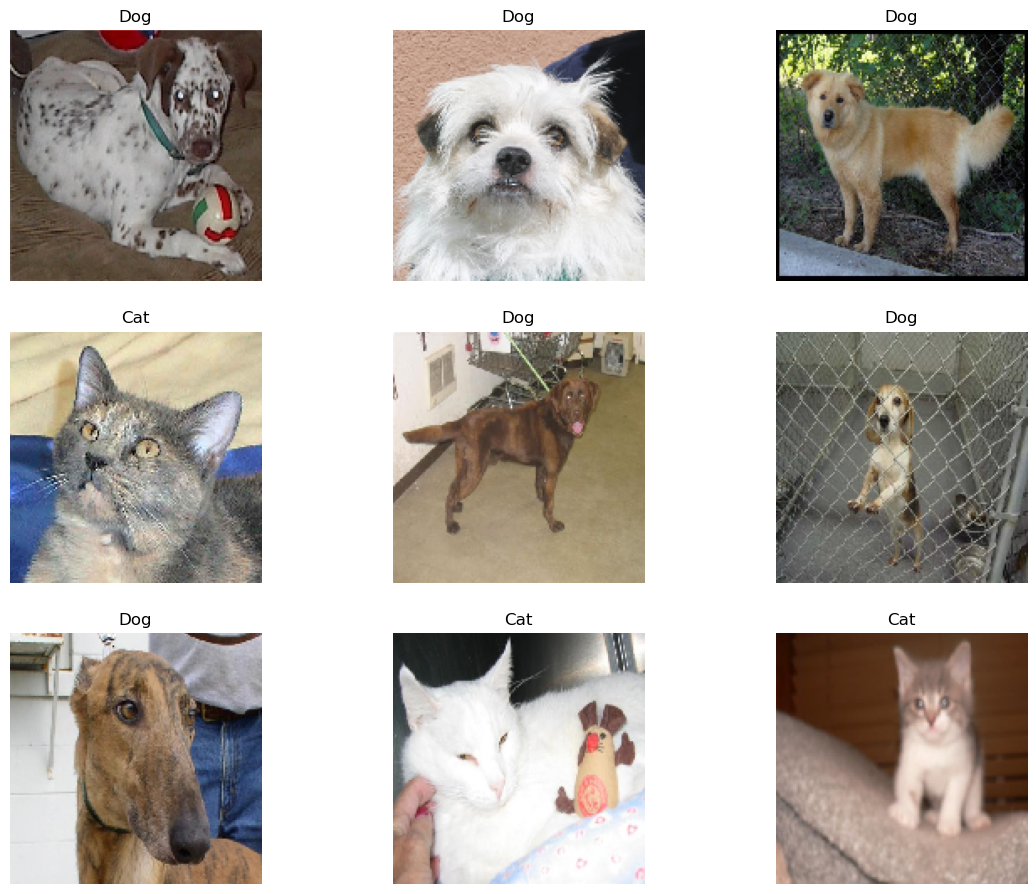

In [31]:
plot_data(train_generator, 10)

# Great, now that the data is ready let's train our model


In [38]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs) # Conv2D(number of filters, kernel size)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [40]:
model.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
  loss='sparse_categorical_crossentropy', 
  metrics=['accuracy']
)

In [41]:
r = model.fit(
  train_generator,
  epochs=10, 
  validation_data=validation_generator
)

Epoch 1/10


200/352 [================>.............] - ETA: 4:52 - loss: 0.6920 - accuracy: 0.5263

c:\Users\Nien\miniconda3\envs\min_ds-env_2\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning:

Truncated File Read



352/352 [==============================] - 702s 2s/step - loss: 0.6830 - accuracy: 0.5519 - val_loss: 0.6456 - val_accuracy: 0.6160
Epoch 2/10
352/352 [==============================] - 708s 2s/step - loss: 0.6469 - accuracy: 0.6260 - val_loss: 0.6460 - val_accuracy: 0.6160
Epoch 3/10
352/352 [==============================] - 711s 2s/step - loss: 0.6055 - accuracy: 0.6773 - val_loss: 0.5566 - val_accuracy: 0.7072
Epoch 4/10
 13/352 [>.............................] - ETA: 11:40 - loss: 0.6001 - accuracy: 0.6767